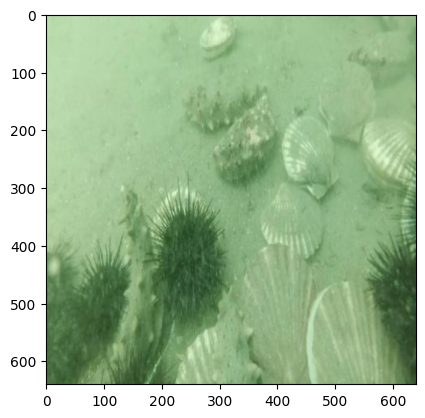

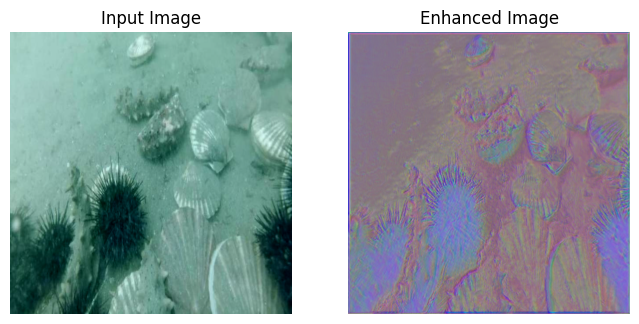

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

class SharedModule(nn.Module):
    def __init__(self):
        super(SharedModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class UnderwaterEnhancementSubnet(nn.Module):
    def __init__(self):
        super(UnderwaterEnhancementSubnet, self).__init__()
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = self.sigmoid(x)
        return x

def increase_contrast(input_tensor, contrast_factor=2.0):
    contrast = transforms.ColorJitter(contrast=contrast_factor)
    return contrast(input_tensor)
# Load the input image using its file path
image_path = "img1.jpg"
i_image = Image.open(image_path)
plt.imshow(i_image)
input_image = i_image.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor
    transforms.Normalize((0.25, 0.25, 0.1), (0.75, 0.75, 0.75))  # Normalize the image
])

input_tensor = preprocess(input_image).unsqueeze(0)  # Add batch dimension
#input_tensor = increase_contrast(input_tensor, contrast_factor=2.0)

# Create instances of SharedModule and UnderwaterEnhancementSubnet
shared_module = SharedModule()
enhancement_subnet = UnderwaterEnhancementSubnet()

# Pass the input image through the shared module and then the enhancement subnet
shared_output = shared_module(input_tensor)
enhanced_image = enhancement_subnet(shared_output)

# Convert PyTorch tensor to numpy array for visualization
input_image_np = input_tensor.squeeze().permute(1, 2, 0).detach().numpy()
enhanced_image_np = enhanced_image.squeeze().permute(1, 2, 0).detach().numpy()

# Display the input and enhanced images using matplotlib
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image_np)
plt.axis("off")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import torchvision.transforms.functional as TF
from torch import nn, optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [ ]:
class SharedModule(nn.Module):
    def __init__(self):
        super(SharedModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class UnderwaterEnhancementSubnet(nn.Module):
    def __init__(self):
        super(UnderwaterEnhancementSubnet, self).__init__()
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = self.sigmoid(x)
        return x

def increase_contrast(input_tensor, contrast_factor):
    #contrast = transforms.ColorJitter(contrast=contrast_factor)
    #return contrast(input_tensor)
    mean = input_tensor.mean()
    adjusted_tensor = (input_tensor - mean) * contrast_factor + mean
    return torch.clamp(adjusted_tensor, 0.0, 1.0)

In [ ]:
#with preprocessing,mse loss
# Load the input images from a folder in Google Drive
data_folder = '/content/drive/My Drive/UOD/DUO/train_50'
image_paths = [os.path.join(data_folder, img) for img in os.listdir(data_folder) if img.endswith('.jpg')]


# Preprocess the images using torchvision.transforms
preprocess = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor
    transforms.Normalize((0.25, 0.25, 0.1), (0.75, 0.75, 0.75))  # Normalize the image
])

# Create a DataLoader for batch processing
batch_size = 1  # Adjust this based on your available memory
data_loader = DataLoader(image_paths, batch_size=batch_size, shuffle=True)

# Create instances of SharedModule and UnderwaterEnhancementSubnet
shared_module = SharedModule()
enhancement_subnet = UnderwaterEnhancementSubnet()

# Define your loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(shared_module.parameters()) + list(enhancement_subnet.parameters()), lr=0.001)

output_folder = '/content/drive/My Drive/UOD/DUO/enhanced_images'
os.makedirs(output_folder, exist_ok=True)

# Training loop for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    for batch_paths in data_loader:
        # Load and preprocess the batch of images
        batch_images = [(Image.open(img_path).convert("RGB")).unsqueeze(0) for img_path in batch_paths]
        batch_images = torch.cat(batch_images, dim=0)
        batch_images = increase_contrast(batch_images, contrast_factor=7.0)

        # Forward pass
        shared_output = shared_module(batch_images)
        enhanced_image = enhancement_subnet(shared_output)

        # Compute the loss
        loss = criterion(enhanced_image, batch_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        '''if epoch == num_epochs - 1:
           for i, img_path in enumerate(batch_paths):
            enhanced_image_path = os.path.join(output_folder, f'enhanced_last_epoch_img{i + 1}.jpg')
            enhanced_image_i = (enhanced_image[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.75 + 0.25).clip(0, 1) * 255
            Image.fromarray(enhanced_image_i.astype('uint8')).save(enhanced_image_path)'''

    # Print the loss after each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')




In [ ]:
#without batch with contrast,mse loss
image_dir = '/content/drive/My Drive/UOD/DUO/train_50'
criterion = nn.MSELoss()
shared_module = SharedModule()
enhancement_subnet = UnderwaterEnhancementSubnet()
optimizer = torch.optim.Adam(list(shared_module.parameters()) + list(enhancement_subnet.parameters()), lr=0.001)
if not os.path.exists(image_dir):
    print(f"Directory {image_dir} does not exist.")
else:
    image_files = [filename for filename in os.listdir(image_dir) if filename.endswith(".jpg") or filename.endswith(".jpeg")]

    for epoch in range(20):
        total_loss = 0  # Initialize total loss for the epoch

        for idx, filename in enumerate(image_files):
            image_path = os.path.join(image_dir, filename)
            input_image = Image.open(image_path)
            # No data transformation for input image
            input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
            input_tensor = increase_contrast(input_tensor, contrast_factor=3.0)
            #input_tensor = F.interpolate(input_tensor, size=(224, 224), mode='bilinear', align_corners=False)
            #print(f"input shape for {filename}: {input_tensor.shape}")

            shared_output = shared_module(input_tensor)
            enhanced_image = enhancement_subnet(shared_output)

            loss = criterion(enhanced_image, input_tensor)
            total_loss += loss.item()

        # Calculate average loss for the epoch
        average_loss = total_loss / len(image_files)

        print(f'Epoch {epoch + 1}, Average Loss: {average_loss}')

        # Perform optimization once after processing all images in the epoch
        optimizer.zero_grad()
        #torch.tensor(average_loss, requires_grad=True).backward()
        loss.backward()
        optimizer.step()

Epoch 1, Average Loss: 0.17834116831421853
Epoch 2, Average Loss: 0.15181265532970428
Epoch 3, Average Loss: 0.1320435369759798
Epoch 4, Average Loss: 0.11454702734947204
Epoch 5, Average Loss: 0.09863993622362614
Epoch 6, Average Loss: 0.08639131903648377
Epoch 7, Average Loss: 0.0765766305476427
Epoch 8, Average Loss: 0.06878840584307909
Epoch 9, Average Loss: 0.06274538468569517
Epoch 10, Average Loss: 0.058117721900343894
Epoch 11, Average Loss: 0.054565077014267445
Epoch 12, Average Loss: 0.05158611681312322
Epoch 13, Average Loss: 0.048879904206842184
Epoch 14, Average Loss: 0.046517167221754786
Epoch 15, Average Loss: 0.044589013252407314
Epoch 16, Average Loss: 0.04314630201086402
Epoch 17, Average Loss: 0.04215697079896927
Epoch 18, Average Loss: 0.041580396555364135
Epoch 19, Average Loss: 0.04126331044360995
Epoch 20, Average Loss: 0.04101247552782297


In [ ]:
# Function to calculate PSNR and SSIM
def calculate_metrics(original_tensor, enhanced_tensor):
    original_np = transforms.ToPILImage()(original_tensor.squeeze(0).cpu()).convert('RGB')
    enhanced_np = transforms.ToPILImage()(enhanced_tensor.squeeze(0).cpu()).convert('RGB')

    # Convert PIL images to NumPy arrays
    original_np = np.array(original_np)
    enhanced_np = np.array(enhanced_np)

    # Calculate PSNR
    psnr_value = psnr(original_np, enhanced_np)

    # Calculate SSIM
    ssim_value = ssim(original_np, enhanced_np, multichannel=True)

    return psnr_value, ssim_value


#with ground truth and mse loss
# Define your image directory and paths
input_image_dir = '/content/drive/My Drive/UOD/DUO/train_try'
ground_truth_image_dir = '/content/drive/My Drive/UOD/DUO/clahe_gt'
output_directory = '/content/drive/My Drive/UOD/DUO/enhanced_images_50'
os.makedirs(output_directory, exist_ok=True)

# Define your neural network modules and optimizer
criterion = nn.MSELoss()
shared_module = SharedModule()
enhancement_subnet = UnderwaterEnhancementSubnet()
optimizer = optim.Adam(list(shared_module.parameters()) + list(enhancement_subnet.parameters()), lr=0.001)

# Check if directories exist
if not os.path.exists(input_image_dir) or not os.path.exists(ground_truth_image_dir):
    print("Directories do not exist.")
else:
    # Get the list of image files in the input image directory
    image_files = [filename for filename in os.listdir(input_image_dir) if filename.endswith(".jpg") or filename.endswith(".jpeg")]

    for epoch in range(30):
        total_loss = 0  # Initialize total loss for the epoch
        total_psnr = 0  # Initialize total PSNR for the epoch
        total_ssim = 0

        for idx, filename in enumerate(image_files):
            # Load input image
            input_image_path = os.path.join(input_image_dir, filename)
            input_image = Image.open(input_image_path)
            input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
            input_tensor = increase_contrast(input_tensor, contrast_factor=5.0)

            # Load ground truth image
            ground_truth_image_path = os.path.join(ground_truth_image_dir, filename)
            ground_truth_image = Image.open(ground_truth_image_path)
            ground_truth_tensor = transforms.ToTensor()(ground_truth_image).unsqueeze(0)

            # Forward pass
            shared_output = shared_module(input_tensor)
            enhanced_image = enhancement_subnet(shared_output)

            # Calculate loss using ground truth
            loss = criterion(enhanced_image, ground_truth_tensor)
            total_loss += loss.item()
            psnr_value, ssim_value = calculate_metrics(ground_truth_tensor, enhanced_image)
            total_psnr += psnr_value
            total_ssim += ssim_value

        # Calculate average loss for the epoch
        average_loss = total_loss / len(image_files)
        average_psnr = total_psnr / len(image_files)
        average_ssim = total_ssim / len(image_files)

        print(f'Epoch {epoch + 1}, Average Loss: {average_loss}, Average PSNR: {average_psnr}, Average SSIM: {average_ssim}')

        # Perform optimization once after processing all images in the epoch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(f'Final Average PSNR: {average_psnr}, Final Average SSIM: {average_ssim}')

<ipython-input-4-6762eaaa2bd7>:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_np, enhanced_np, multichannel=True)


Epoch 1, Average Loss: 0.04694336336106062, Average PSNR: 13.55136069028456, Average SSIM: 0.4323602353482554
Epoch 2, Average Loss: 0.030346866808831693, Average PSNR: 15.554626528362157, Average SSIM: 0.5418937223306021
Epoch 3, Average Loss: 0.02454002236947417, Average PSNR: 16.602166185793624, Average SSIM: 0.5967032888235008
Epoch 4, Average Loss: 0.022737093446776272, Average PSNR: 16.991581465948872, Average SSIM: 0.6219850935392324
Epoch 5, Average Loss: 0.021209016535431148, Average PSNR: 17.331538575475914, Average SSIM: 0.6420689962399918
Epoch 6, Average Loss: 0.020650347443297506, Average PSNR: 17.47533274135563, Average SSIM: 0.6498423249066141
Epoch 7, Average Loss: 0.020774096501991152, Average PSNR: 17.456307814318272, Average SSIM: 0.6513268368141937
Epoch 8, Average Loss: 0.02130745951551944, Average PSNR: 17.346587712718048, Average SSIM: 0.6499336981727991
Epoch 9, Average Loss: 0.022008410124108195, Average PSNR: 17.193996268253557, Average SSIM: 0.64742860353203

In [ ]:
for filename in image_files:
    # Load input image
    input_image_path = os.path.join(input_image_dir, filename)
    input_image = Image.open(input_image_path)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
    input_tensor = increase_contrast(input_tensor, contrast_factor=5.0)

    # Forward pass
    shared_output = shared_module(input_tensor)
    enhanced_image = enhancement_subnet(shared_output)

    # Save the enhanced image
    output_image_path = os.path.join(output_directory, filename)
    enhanced_image = transforms.ToPILImage()(enhanced_image.squeeze(0).detach().cpu())
    enhanced_image.save(output_image_path)

print("Enhanced images saved to:", output_directory)

In [ ]:
from torchvision.models import vgg16
import torch.optim as optim
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:16])
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        features_x = self.feature_extractor(x)
        features_y = self.feature_extractor(y)
        loss = nn.functional.mse_loss(features_x, features_y)
        return loss


In [ ]:
#with perceptual loss

image_dir = '/content/drive/My Drive/UOD/DUO/train_50'
perceptual_criterion = PerceptualLoss()
shared_module = SharedModule()
enhancement_subnet = UnderwaterEnhancementSubnet()
optimizer = optim.Adam(list(shared_module.parameters()) + list(enhancement_subnet.parameters()), lr=0.001)

if not os.path.exists(image_dir):
    print(f"Directory {image_dir} does not exist.")
else:
    image_files = [filename for filename in os.listdir(image_dir) if filename.endswith(".jpg") or filename.endswith(".jpeg")]

    for epoch in range(30):
        total_loss = 0  # Initialize total loss for the epoch

        for idx, filename in enumerate(image_files):
            image_path = os.path.join(image_dir, filename)
            input_image = Image.open(image_path)
            input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
            input_tensor = increase_contrast(input_tensor, contrast_factor=5.0)

            shared_output = shared_module(input_tensor)
            enhanced_image = enhancement_subnet(shared_output)

            perceptual_loss = perceptual_criterion(enhanced_image, input_tensor)
            total_loss += perceptual_loss.item()

        # Calculate average loss for the epoch
        average_loss = total_loss / len(image_files)

        print(f'Epoch {epoch + 1}, Average Loss: {average_loss}')

        # Perform optimization once after processing all images in the epoch
        optimizer.zero_grad()
        perceptual_loss.backward()
        optimizer.step()


Epoch 1, Average Loss: 1.3187417602539062
Epoch 2, Average Loss: 1.1359648805856706
Epoch 3, Average Loss: 0.988984358906746
Epoch 4, Average Loss: 0.9124276709556579
Epoch 5, Average Loss: 0.8445124530792236
Epoch 6, Average Loss: 0.7871190989017487
Epoch 7, Average Loss: 0.7609130299091339
Epoch 8, Average Loss: 0.7509155690670013
Epoch 9, Average Loss: 0.7459388101100921
Epoch 10, Average Loss: 0.7390253102779388
Epoch 11, Average Loss: 0.7328481853008271
Epoch 12, Average Loss: 0.7208701658248902
Epoch 13, Average Loss: 0.6947596943378449
Epoch 14, Average Loss: 0.6695456385612488
Epoch 15, Average Loss: 0.6585655629634857
Epoch 16, Average Loss: 0.6603041362762451
Epoch 17, Average Loss: 0.6708040219545365
Epoch 18, Average Loss: 0.6803337639570236
Epoch 19, Average Loss: 0.6839970707893371
Epoch 20, Average Loss: 0.6839029166102409
Epoch 21, Average Loss: 0.6819096413254738
Epoch 22, Average Loss: 0.6796224156022072
Epoch 23, Average Loss: 0.678557762503624
Epoch 24, Average Loss

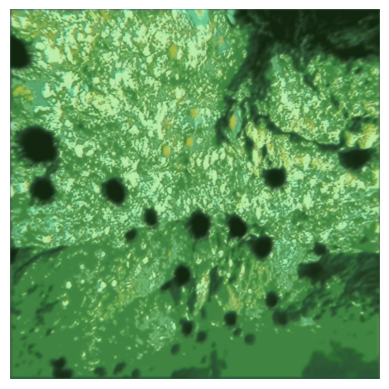

In [ ]:
enhanced_image_np = enhanced_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Display the enhanced image using matplotlib
plt.imshow(enhanced_image_np)
plt.axis('off')
plt.show()

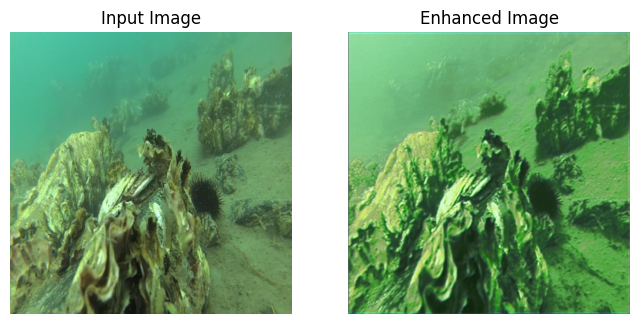

In [ ]:
sample_image_path = 'img_bl.jpg'  # Choose any image from the dataset for visualization
sample_image = Image.open(sample_image_path).convert("RGB")
sample_input = transforms.ToTensor()(sample_image).unsqueeze(0)
sample_shared_output = shared_module(sample_input)
sample_enhanced_image = enhancement_subnet(sample_shared_output)

# Convert PyTorch tensor to numpy array for visualization
sample_input_np = sample_input.squeeze().permute(1, 2, 0).detach().numpy()
sample_enhanced_np = sample_enhanced_image.squeeze().permute(1, 2, 0).detach().numpy()

# Display the input and enhanced images using matplotlib
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(sample_input_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(sample_enhanced_np)
plt.axis("off")

plt.show()